# Sparkify 项目
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [47]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, sum as Fsum, current_date,\
from_unixtime, datediff, current_date, countDistinct, month, substring, count, when, isnull
from pyspark.sql.types import IntegerType, StringType, FloatType, DateType, Row

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer,PCA, RegexTokenizer, StandardScaler, StopWordsRemover,\
StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import DenseVector, SparseVector

import re
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Spark Project").getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
data_path = "mini_sparkify_event_data.json"

In [4]:
df = spark.read.json(data_path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

查看数据集

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# 查看访问页面的种类
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



因为需要使用userId进行聚合，查看是否存在userId为空的数据，并将其删除

In [7]:
df.filter("userId = ''").count()

8346

In [8]:
df = df.filter("userId != ''")
df.count()

278154

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [9]:
flag_cancel_confirmation = udf(lambda x : 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("cancelled", flag_cancel_confirmation("page"))

In [10]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding,0)

df = df.withColumn("churn",Fsum("cancelled").over(windowval))

1 查看用户性别比例，以及是否注销与性别的关系

In [11]:
gender = df.dropDuplicates(["userId","gender"]).groupby(["churn","gender"]).count().toPandas()

Text(0.5,1,'churn_gender')

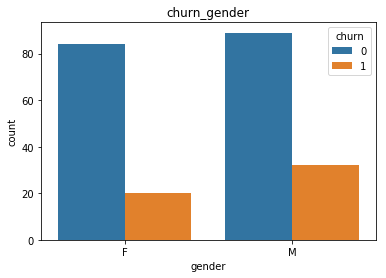

In [12]:
sns.barplot(x="gender", y="count", hue="churn",data=gender).set_title("churn_gender")

- 总量流失使用中男性多于女性，但差别不大

2 查看付费用户与免费用户中流失用户数量的差别

Text(0.5,1,'churn_level')

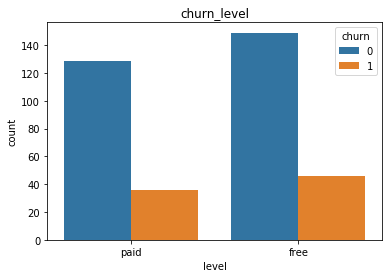

In [13]:
gender = df.dropDuplicates(["userId","level"]).groupby(["churn","level"]).count().toPandas()
sns.barplot(x="level", y="count", hue="churn",data=gender).set_title("churn_level")

- 付费用户与免费用户流失比例相差不大

3 查看注销与否和注册时长的关系

In [14]:
reg_time_churn = df.filter("churn = 1").groupBy("userId").agg({"ts":"max","registration":"max"})\
.withColumnRenamed("max(ts)", "max_ts").withColumnRenamed("max(registration)", "reg")
cal_reg = udf(lambda x,y : (x-y)/86400000, FloatType())
reg_time_churn = reg_time_churn.withColumn("reg_time",cal_reg(reg_time_churn.max_ts,reg_time_churn.reg)).toPandas()

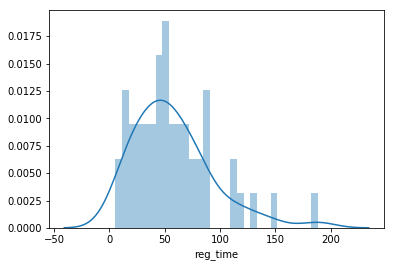

In [15]:
sns.distplot(reg_time_churn.reg_time, bins = 30,hist=True,label = 'reg')

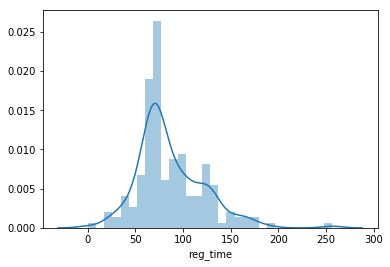

In [16]:
reg_time = df.filter("churn = 0").groupBy("userId").agg({"ts":"max","registration":"max"})\
.withColumnRenamed("max(ts)", "max_ts").withColumnRenamed("max(registration)", "reg")
cal_reg = udf(lambda x,y : (x-y)/86400000, FloatType())
reg_time = reg_time.withColumn("reg_time",cal_reg(reg_time.max_ts,reg_time.reg)).toPandas()
sns.distplot(reg_time.reg_time, bins = 30,hist=True,label = 'reg')

- 注销的用户的注册时间在100天以内的居多,集中在注册50天左右

4 查看itemInSession与是否注销的关系

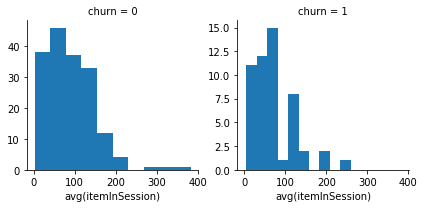

In [17]:
itemInSession_df = df.groupBy(['userId','churn']).avg('itemInSession').toPandas()
g = sns.FacetGrid(itemInSession_df, col="churn", sharey=False)
g.map(plt.hist, "avg(itemInSession)");

- 由于数据的量比较小，分布差别不大

5 查看地区与注销与否的关系

In [18]:
df = df.withColumn('state',substring(col('location'), -2, 3))

df.groupBy(['churn','state']).count().where(df['churn']==0).sort(col('count').desc()).show(5)
df.groupBy(['churn','state']).count().where(df['churn']==1).sort(col('count').desc()).show(5)

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    0|   CA|39158|
|    0|   PA|23708|
|    0|   TX|22200|
|    0|   NH|18637|
|    0|   FL|11427|
+-----+-----+-----+
only showing top 5 rows

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    1|   CA| 7613|
|    1|   CO| 4317|
|    1|   MS| 3839|
|    1|   WA| 3526|
|    1|   OH| 3173|
+-----+-----+-----+
only showing top 5 rows



In [19]:
print(df.select('state').distinct().count())
print(df.select('userId').distinct().count())

39
225


- 值得注意的是，user一共就225个但是地区就有39个

6 查看userAgent与用户是否注销的关系


In [20]:
find_user_agent = udf(lambda x : re.findall(r"Mozilla/5.0 \((.+?)\)",x),StringType())
df = df.withColumn('new_ua',find_user_agent('userAgent'))

In [21]:
df.filter('churn = 1').groupby('new_ua').count().sort(col('count').desc()).show()

+--------------------+-----+
|              new_ua|count|
+--------------------+-----+
|[Macintosh; Intel...|11140|
|[Windows NT 6.1; ...| 7129|
|[Windows NT 6.1; ...| 3437|
|[Windows NT 6.3; ...| 3003|
|[Macintosh; Intel...| 2462|
|    [Windows NT 5.1]| 2168|
|[Windows NT 6.2; ...| 2149|
|[Macintosh; Intel...| 2064|
|[Windows NT 6.1; ...| 1781|
|[X11; Ubuntu; Lin...| 1557|
|[Macintosh; Intel...| 1502|
|[Windows NT 6.1; ...| 1476|
|    [Windows NT 6.1]| 1392|
|[Windows NT 6.1; ...| 1102|
|[Windows NT 6.3; ...| 1064|
|[iPhone; CPU iPho...| 1010|
|[Macintosh; Intel...|  187|
| [X11; Linux x86_64]|  143|
|[X11; Ubuntu; Lin...|   62|
|[Windows NT 6.1; ...|   36|
+--------------------+-----+



In [22]:
df.filter('churn = 0').groupby('new_ua').count().sort(col('count').desc()).show()

+--------------------+-----+
|              new_ua|count|
+--------------------+-----+
|[Macintosh; Intel...|61529|
|[Windows NT 6.1; ...|51892|
|[Windows NT 6.1; ...|15224|
|[Windows NT 6.3; ...| 9538|
|[iPad; CPU OS 7_1...| 8912|
|    [Windows NT 6.1]| 8663|
|[compatible; MSIE...| 8624|
|[Macintosh; Intel...| 7838|
|[Macintosh; Intel...| 7038|
|[iPhone; CPU iPho...| 5407|
|    [Windows NT 5.1]| 5238|
|[Windows NT 6.3; ...| 4925|
| [X11; Linux x86_64]| 4338|
|[Windows NT 6.2; ...| 3278|
|[Windows NT 6.1; ...| 3214|
|[Windows NT 6.1; ...| 2882|
|[iPhone; CPU iPho...| 2799|
|[X11; Linux x86_6...| 2544|
|[iPad; CPU OS 7_1...| 2469|
|[Windows NT 6.0; ...| 2442|
+--------------------+-----+
only showing top 20 rows



# 特征工程  
我决定使用以下特征值  
- 注册天数
- 每天访问次数

In [23]:
# 注册时间->注册日期
df = df.withColumn("reg_date",from_unixtime(col('registration')/1000).cast(DateType()))

# 注册日期->注册天数
df = df.withColumn("days_since_reg", datediff(current_date(), col('reg_date')))

In [24]:
# 每天访问次数
# ts -> Date
df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
# Date -> month
df = df.withColumn('month',month('date'))
# 计算每天的访问次数
day_df = df.groupBy(['userId','date']).agg(countDistinct('sessionId')).groupBy('userId')\
.avg('count(DISTINCT sessionId)').withColumnRenamed('avg(count(DISTINCT sessionId))','daily_session')
df = df.join(day_df, on='userId')
# 计算每个月的平均访问天数
month_df = df.groupBy(['userId','month']).agg(countDistinct('date')).groupBy('userId')\
.avg('count(DISTINCT date)').withColumnRenamed('avg(count(DISTINCT date))','monthly_day')
df = df.join(month_df, on='userId')

In [25]:
# 统计各个page的访问数量
for p in ['Downgrade','Roll Advert','Thumbs Down','Add to Playlist','Add Friend','Thumbs Up']:
    df = df.withColumn(p, (df['page']==p).cast(IntegerType()))

In [26]:
features = df.groupBy('userId').agg({'itemInSession':'avg',
                                   'length':'avg',
                                   'daily_session':'min',
                                   'monthly_day':'min',
                                   'days_since_reg':'min',
                                   'level':'max',
                                   'new_ua':'max',
                                   'state':'max',
                                   'churn':'max',
                                   'Downgrade':'sum',
                                   'Roll Advert':'sum',
                                   'Thumbs Down':'sum',
                                   'Add to Playlist':'sum',
                                   'Add Friend':'sum',
                                   'Thumbs Up':'sum'})
                                   

features = features.select(col('avg(itemInSession)').alias('itemInSession'),
                                 col('avg(length)').alias('length'),
                                 col('min(daily_session)').alias('daily_session'),
                                 col('min(monthly_day)').alias('monthly_day'),
                                 col('min(days_since_reg)').alias('days_since_reg'),
                  col('max(level)').alias('level'),
                  col('max(new_ua)').alias('userAgent'),
                  col('max(state)').alias('state'),
                  col('sum(Downgrade)').alias('downgrade'),
                  col('sum(Roll Advert)').alias('rollAdvert'),
                  col('sum(Thumbs Down)').alias('thumbsDown'),
                  col('sum(Add to Playlist)').alias('addToPlaylist'),
                  col('sum(Add Friend)').alias('addFriend'),
                  col('sum(Thumbs Up)').alias('thumbsUp'),
                  col('max(churn)').alias('label'))

In [27]:
# 查看有没有空值
features.select([count(when(isnull(c), c)).alias(c) for c in features.columns]).show()

+-------------+------+-------------+-----------+--------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+
|itemInSession|length|daily_session|monthly_day|days_since_reg|level|userAgent|state|downgrade|rollAdvert|thumbsDown|addToPlaylist|addFriend|thumbsUp|label|
+-------------+------+-------------+-----------+--------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+
|            0|     0|            0|          0|             0|    0|        0|    0|        0|         0|         0|            0|        0|       0|    0|
+-------------+------+-------------+-----------+--------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+



# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [36]:
indexer_state = StringIndexer(inputCol='state', outputCol='state_index')
indexer_level = StringIndexer(inputCol='level', outputCol='level_index')
indexer_ua = StringIndexer(inputCol='userAgent', outputCol='userAgent_index')
# 将各个特征整合成向量
assembler = VectorAssembler(inputCols=[#'itemInSession',
                                      'length',
                                      'daily_session',
                                      'monthly_day',
                                      'days_since_reg',
                                      'level_index',
                                      #'state_index',
                                      #'userAgent_index',
                                      'downgrade',
                                      'rollAdvert',
                                      'thumbsDown',
                                      'addToPlaylist',
                                      'addFriend',
                                      'thumbsUp'], outputCol='NumFeatures')
# 使用
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features")

features_pipeline = Pipeline(stages=[indexer_state, indexer_level, indexer_ua, assembler, scaler])

model_df = features_pipeline.fit(features).transform(features)

In [48]:
# 将稀疏向量转成稠密向量
model_df_clean = model_df.select(['label','features'])
df2 = model_df.select("label", "features")
rdd = df2.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray()))
                     if (len(x)>1 and hasattr(x[1], "toArray"))
                     else Row(label=None, features=DenseVector([])))
model_data = spark.createDataFrame(rdd)

In [49]:
# 分割训练集和测试集
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

In [39]:
def cal_f1_score(train,test,model):
    start_time = time.time()
    result = model.fit(train)
    prediction = result.transform(test)
    end_time = time.time()
    
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(prediction.select(col('label'), col('prediction')))
    print('Run Time is {}'.format(np.round(((end_time - start_time)/60),2)))
    print('The F1-Score is {}'.format(f1_score))

In [50]:
train.head(5)

[Row(features=DenseVector([40.8826, 5.4418, 0.6554, 17.8695, 0.0, 0.4261, 0.3248, 0.4588, 0.2445, 0.1943, 0.3207]), label=0),
 Row(features=DenseVector([43.9493, 5.4418, 0.1872, 18.9543, 2.2563, 0.0, 0.0464, 0.0, 0.0, 0.0, 0.0]), label=1),
 Row(features=DenseVector([41.7179, 6.6977, 2.4342, 17.2366, 0.0, 1.96, 0.0, 1.6058, 1.5894, 1.3604, 1.5272]), label=1),
 Row(features=DenseVector([42.6739, 5.4418, 0.749, 17.7188, 2.2563, 0.0, 0.7425, 0.0765, 0.1528, 0.0486, 0.1069]), label=0),
 Row(features=DenseVector([42.1395, 8.6016, 2.9023, 19.1652, 0.0, 3.3236, 2.181, 2.2176, 2.2007, 1.6034, 2.4894]), label=1)]

In [51]:
# 逻辑回归
model = LogisticRegression()
cal_f1_score(train,test,model)

# 随机森林
model = RandomForestClassifier()
cal_f1_score(train,test,model)

# 集成方法
model = GBTClassifier()
cal_f1_score(train,test,model)

Run Time is 4.57
The F1-Score is 0.7638831756478816
Run Time is 1.67
The F1-Score is 0.686815415821501
Run Time is 6.31
The F1-Score is 0.6097105508870214


目前看起来逻辑回归的效果最好，我们调整一下参数尝试

In [53]:
lrs =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lrs.maxIter, [10, 20]) \
    .addGrid(lrs.elasticNetParam,[0.0, 0.5]) \
    .addGrid(lrs.regParam,[0.01, 0.1]) \
    .build()

crossval = CrossValidator(estimator = Pipeline(stages=[lrs]),
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

classification = crossval.fit(train)
results = classification.transform(test)

# 计算准确率和f1分数
accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(results.select(col('label'), col('prediction')))

f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))

print('For {}, the accuracy on the test set is {:.2%} and the F-1 score is {}'\
.format(model, accuracy, f1_score))

For GBTClassifier_eca1efb60705, the accuracy on the test set is 79.41% and the F-1 score is 0.7412515245332583


### 总结
- 本次由于数据集较小可能会导致测试集上的预测准确率下降
- 尝试了逻辑回归模型，决策树和集成方法，其中逻辑回归的f1分数最高
- 一开始使用MinMaxScaler进行转换，结果一些较小的值都被转换为0，导致预测精度下降
- 本次项目是根据截至当前的用户行为数据来预测用户是否注销，但是实际上工作中肯定预测的是未来一段时间用户是否注销。
- 本次使用的特征以外，细想一下还有很多特征值得尝试，譬如喜欢的音乐家数量，听歌数量，所在地变更情况等等
